# Eye tracking validation

1. Tabulate center-out reaching trials
1. Load eye and cursor trajectories at timepoints when the cursor enters targets 
1. Perform linear regression on X and Y data to find calibration coefficients

In [1]:
import aopy
from aopy.data import db
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

/home/aolab/miniconda3/envs/leo-analysis/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(
/home/aolab/miniconda3/envs/leo-analysis/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_dir = '/data/human'
preproc_dir = '/data/preprocessed-human'

db.BMI3D_DBNAME = 'human'
entries = db.lookup_mc_sessions(id=[757])
for e in entries:
    print(f"\033[1m{e.id}\033[0;0m {e.subject} on {e.task_name} task ({e.task_desc})\nProject: {e.project}, session: {e.session}\nNotes: {e.notes}")
    e.preprocess(data_dir, preproc_dir, exclude_sources=['eye'])
    print()

757 Hayden on manual control task (pupillab test optitrack)
Project: pilot, session: a1
Notes: 
Updating hdf file with metadata for task entry 757
/data/human/hdf/hayd20240916_05_te757.hdf
processing experiment data...
File preproc_2024-09-16_Hayden_757_exp.hdf already preprocessed, doing nothing.



## Tabulate trials

In [3]:
subjects, ids, dates = db.list_entry_details(entries)

In [4]:
df = aopy.data.tabulate_behavior_data_center_out(preproc_dir, subjects, ids, dates, 
                                                 metadata=['target_radius', 'session'])
display(df[:5])

  0%|          | 0/1 [00:00<?, ?it/s]

,subject,te_id,date,event_codes,event_times,reward,penalty,target_radius,session,target_idx,...,hold_start_time,hold_completed,delay_start_time,delay_completed,go_cue_time,reach_completed,reach_end_time,reward_start_time,penalty_start_time,penalty_event
0,Hayden,757,2024-09-16,"[16, 80, 20, 32, 84, 48, 239]","[0.5072054140000546, 1.615329727000244, 1.8253...",True,False,1.0,a1,4,...,1.615330,True,1.825337,True,1.840799,True,3.203823,3.446179,NaN,NaN
1,Hayden,757,2024-09-16,"[16, 80, 19, 32, 83, 48, 239]","[4.058257474999664, 5.067224960999738, 5.27545...",True,False,1.0,a1,3,...,5.067225,True,5.275457,True,5.291136,True,6.656390,6.899182,NaN,NaN
2,Hayden,757,2024-09-16,"[16, 80, 24, 32, 88, 48, 239]","[7.51270858099997, 8.544314605999716, 8.753769...",True,False,1.0,a1,8,...,8.544315,True,8.753769,True,8.769343,True,9.971993,10.213722,NaN,NaN
3,Hayden,757,2024-09-16,"[16, 80, 17, 32, 81, 48, 239]","[10.838595288999386, 11.835475781999776, 12.04...",True,False,1.0,a1,1,...,11.835476,True,12.045272,True,12.061836,True,13.342592,13.583723,NaN,NaN
4,Hayden,757,2024-09-16,"[16, 80, 23, 32, 87, 48, 239]","[14.21119772899965, 15.251263594000193, 15.460...",True,False,1.0,a1,7,...,15.251264,True,15.460028,True,15.476345,True,17.085509,17.326300,NaN,NaN


In [5]:
# Choose the data you're interested in
df_subset = df[df['reach_completed']].reset_index()
display(df_subset[:5])

,index,subject,te_id,date,event_codes,event_times,reward,penalty,target_radius,session,...,hold_start_time,hold_completed,delay_start_time,delay_completed,go_cue_time,reach_completed,reach_end_time,reward_start_time,penalty_start_time,penalty_event
0,0,Hayden,757,2024-09-16,"[16, 80, 20, 32, 84, 48, 239]","[0.5072054140000546, 1.615329727000244, 1.8253...",True,False,1.0,a1,...,1.615330,True,1.825337,True,1.840799,True,3.203823,3.446179,NaN,NaN
1,1,Hayden,757,2024-09-16,"[16, 80, 19, 32, 83, 48, 239]","[4.058257474999664, 5.067224960999738, 5.27545...",True,False,1.0,a1,...,5.067225,True,5.275457,True,5.291136,True,6.656390,6.899182,NaN,NaN
2,2,Hayden,757,2024-09-16,"[16, 80, 24, 32, 88, 48, 239]","[7.51270858099997, 8.544314605999716, 8.753769...",True,False,1.0,a1,...,8.544315,True,8.753769,True,8.769343,True,9.971993,10.213722,NaN,NaN
3,3,Hayden,757,2024-09-16,"[16, 80, 17, 32, 81, 48, 239]","[10.838595288999386, 11.835475781999776, 12.04...",True,False,1.0,a1,...,11.835476,True,12.045272,True,12.061836,True,13.342592,13.583723,NaN,NaN
4,4,Hayden,757,2024-09-16,"[16, 80, 23, 32, 87, 48, 239]","[14.21119772899965, 15.251263594000193, 15.460...",True,False,1.0,a1,...,15.251264,True,15.460028,True,15.476345,True,17.085509,17.326300,NaN,NaN


## Load cursor and eye kinematics

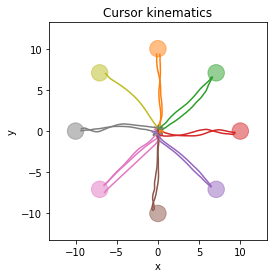

In [6]:
# Can also choose the data segments
# Load the reach segments from go cue until peripheral target entry
plt.figure()
kin_segments = aopy.data.bmi3d.tabulate_kinematic_data(
    preproc_dir, df_subset['subject'], df_subset['te_id'], df_subset['date'], 
    df_subset['hold_start_time'], df_subset['reach_end_time'], datatype='cursor', samplerate=60
)
target_idx = df_subset['target_idx'].to_numpy()
aopy.visualization.color_trajectories(kin_segments[:16], target_idx[:16], sns.color_palette(n_colors=9), bounds=(-12,12,-12,12))
aopy.visualization.color_targets(df_subset['target_location'], df_subset['target_idx'], sns.color_palette(n_colors=9), df_subset['target_radius'][0])
plt.title('Cursor kinematics')
plt.show()

/home/aolab/leo/analyze/aopy/precondition/base.py:739: RuntimeWarning: Mean of empty slice
  downsampled[:, idx] = np.nanmean(data_padded[:, idx].reshape(-1, downsample_factor), axis=1)


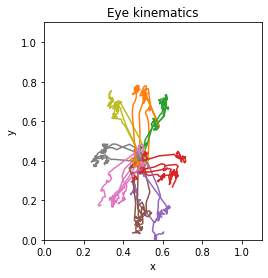

In [7]:
# Load raw eye kinematics
eye_segments, samplerate = aopy.data.bmi3d.tabulate_task_data(
        preproc_dir, df_subset['subject'], df_subset['te_id'], df_subset['date'], 
    df_subset['hold_start_time'], df_subset['reach_end_time'], datatype='eye', remove_nan=False
)
left_eye_segments = [seg[:,:2] for seg in eye_segments]
aopy.visualization.color_trajectories(left_eye_segments[:100], target_idx[:100], sns.color_palette(n_colors=9), bounds=(0,1,0,1))
aopy.visualization.color_targets(df_subset['target_location'], df_subset['target_idx'], sns.color_palette(n_colors=9), df_subset['target_radius'][0])
plt.title('Eye kinematics')
plt.show()

## Calibrate

In [8]:
# Get calibration timepoints
n_train = 12
cursor_data_samples = np.array([seg[-1] for seg in kin_segments[:n_train+1]])
eye_data_samples = np.array([seg[-1,:2] for seg in eye_segments[:n_train+1]])

In [9]:
# Calibrate the eye data
if eye_data_samples.shape[1] == 4:
    cursor_data_samples = np.tile(cursor_data_samples, (1, 2)) # for two eyes
slopes, intercepts, correlation_coeff = aopy.analysis.fit_linear_regression(eye_data_samples, cursor_data_samples)
coeff = np.vstack((slopes, intercepts)).T

In [10]:
print(coeff)

[[ 54.76994245 -26.87266468]
 [ 27.91895307 -10.813797  ]]


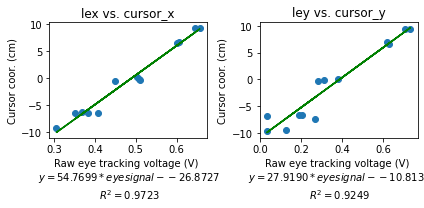

In [11]:
estimated_calibration_pos = aopy.postproc.get_calibrated_eye_data(eye_data_samples, coeff)
fig, ax = plt.subplots(1,2, figsize=(6,3))
for i in range(2):
    eye_label = ['lex', 'ley', 'rex', 'rey'][i]#eye_metadata['labels'][i].decode('utf-8')
    cursor_label = ['cursor_x', 'cursor_y'][i % 2]

    ax[i].set_title(f'{eye_label} vs. {cursor_label}')
    ax[i].scatter(eye_data_samples[:,i], cursor_data_samples[:,i])
    ax[i].plot(eye_data_samples[:,i], estimated_calibration_pos[:,i], 'g')
    ax[i].set_xlabel(f"Raw eye tracking voltage (V) \n $y = {coeff[i,0]:.4f} *eye signal - {coeff[i,1]:.4f}$ \n $R^2 = {correlation_coeff[i]**2:.4f}$ ")
    ax[i].set_ylabel('Cursor coor. (cm)')
#         ax[i].set(adjustable='box-forced', aspect='equal')

plt.tight_layout()


## Validate calibration

(15, 2)


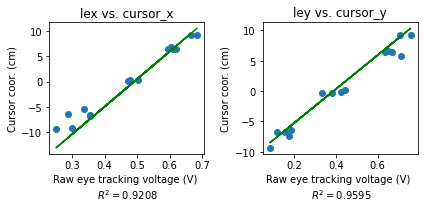

In [12]:
# Test
cursor_data_samples = np.array([seg[-1] for seg in kin_segments[n_train:]])
eye_data_samples = np.array([seg[-1,:2] for seg in eye_segments[n_train:]])
print(eye_data_samples.shape)
if eye_data_samples.shape[1] == 4:
    cursor_data_samples = np.tile(cursor_data_samples, (1, 2)) # for two eyes

estimated_calibration_pos = aopy.postproc.get_calibrated_eye_data(eye_data_samples, coeff)
fig, ax = plt.subplots(1,2, figsize=(6,3))
for i in range(2):
    eye_label = ['lex', 'ley', 'rex', 'rey'][i]#eye_metadata['labels'][i].decode('utf-8')
    cursor_label = ['cursor_x', 'cursor_y'][i % 2]

    ax[i].set_title(f'{eye_label} vs. {cursor_label}')
    ax[i].scatter(eye_data_samples[:,i], cursor_data_samples[:,i])
    ax[i].plot(eye_data_samples[:,i], estimated_calibration_pos[:,i], 'g')
    
    ss_res = np.sum((cursor_data_samples[:,i] - estimated_calibration_pos[:,i]) ** 2)
    ss_tot = np.sum((cursor_data_samples[:,i] - np.mean(cursor_data_samples[:,i])) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    ax[i].set_xlabel(f"Raw eye tracking voltage (V) \n $R^2 = {r2:.4f}$ ")
    ax[i].set_ylabel('Cursor coor. (cm)')
#         ax[i].set(adjustable='box-forced', aspect='equal')

plt.tight_layout()

Text(0.5, 1.0, 'Left eye')

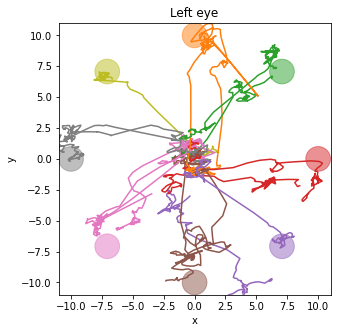

In [13]:
# Load calibrated eye kinematics
def calib(eye, samplerate):
    eye, samplerate = aopy.precondition.filter_eye(eye, samplerate, low_cut=59)
    eye = aopy.postproc.get_calibrated_eye_data(eye[:,:2], coeff)
    return eye, samplerate
eye_segments_calib, samplerate = aopy.data.bmi3d.tabulate_task_data(
        preproc_dir, df_subset['subject'], df_subset['te_id'], df_subset['date'], 
    df_subset['hold_start_time'], df_subset['reach_end_time'], datatype='eye', samplerate=120, preproc=calib
)

left_eye_segments = [seg[:,:2] for seg in eye_segments_calib]
plt.figure(figsize=(5,5))
aopy.visualization.color_trajectories(left_eye_segments[:16], target_idx[:16], sns.color_palette(n_colors=9), bounds=(-10,10,-10,10))
aopy.visualization.color_targets(df_subset['target_location'], df_subset['target_idx'], sns.color_palette(n_colors=9), df_subset['target_radius'][0])
plt.title('Left eye')
